# Construisez un modèle de scoring

## Introduction

<div>
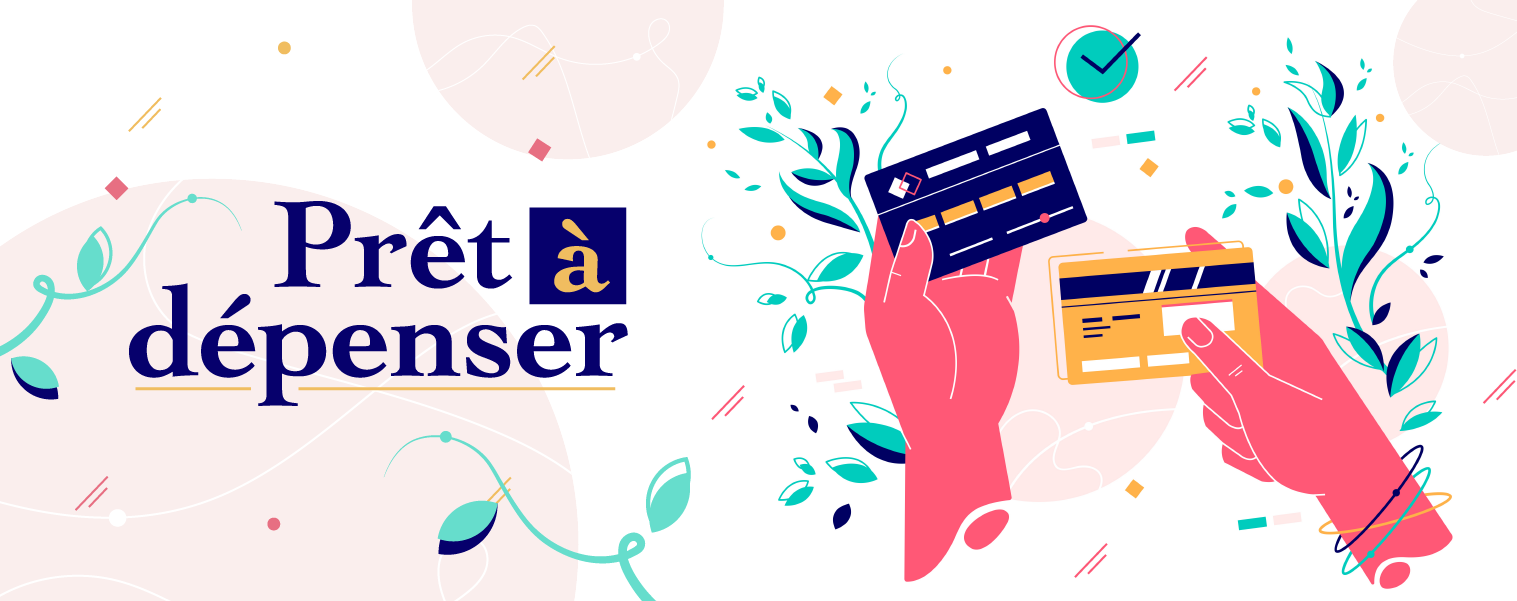
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- [Description des colonnes](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display  

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

Regardons nos fichiers disponibles:

In [2]:
pd.DataFrame(os.listdir("../input/data/"), columns=["Nom des fichiers"])

,Nom des fichiers
0,application_test.csv
1,HomeCredit_columns_description.csv
2,POS_CASH_balance.csv
3,credit_card_balance.csv
4,installments_payments.csv
5,application_train.csv
6,bureau.csv
7,.ipynb_checkpoints
8,previous_application.csv
9,bureau_balance.csv


- [Description des fichiers](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Data)
- [Description de chaque colonne](./../input/HomeCredit_columns_description.csv)

---

On va se concentrer sur **2 fichiers** qui contiennent le plus de données pour commencer:
- application_test.csv
- application_train.csv

On remarque que le fichier **application_train.csv** est le seul à avoir la colonne TARGET.  
Quand la valeur = 1, le client a eu des difficultés de paiement.  
Quand la valeur = 0, le client n'a pas eu de difficulté.

C'est ce qu'on va chercher à prédire dans les 2 fichiers.

In [3]:
# Load the 2 files
app_train = pd.read_csv('../input/data/application_train.csv')
app_test = pd.read_csv('../input/data/application_test.csv')
print('On observe les lignes et colonnes du fichier de training:', app_train.shape)

On observe les lignes et colonnes du fichier de training: (307511, 122)


Parmis les colonnes existantes, je préfère retirer toute colonnes qui ne sont pas éthiques pour éviter de potentiel bias dans les résultats.  
Je les retire des 2 fichiers.

In [4]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER", # Gender of the client
    "DAYS_BIRTH", # Client's age in days at the time of application
]

# Dropping unethical columns
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


J'observe les types de mes différentes variables.

In [5]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
Name: count, dtype: int64

In [6]:
app_train.shape

(307511, 120)

Je remarque que j'ai 15 colonnes de type object, je vais surement devoir les encoder en fonction du nombre de valeurs unique.  
Je vais déjà stocker les colonnes de chaque type dans des variables différentes.

In [7]:
col_type_int64 = app_train.select_dtypes('int64').columns
col_type_float64 = app_train.select_dtypes('float64').columns
col_type_object = app_train.select_dtypes('object').columns

J'affiche les valeurs manquantes pour chaque type.

### Inspection du type Int64

#### _Code de génération de graphique_

In [8]:
def display_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()

#### Résultat

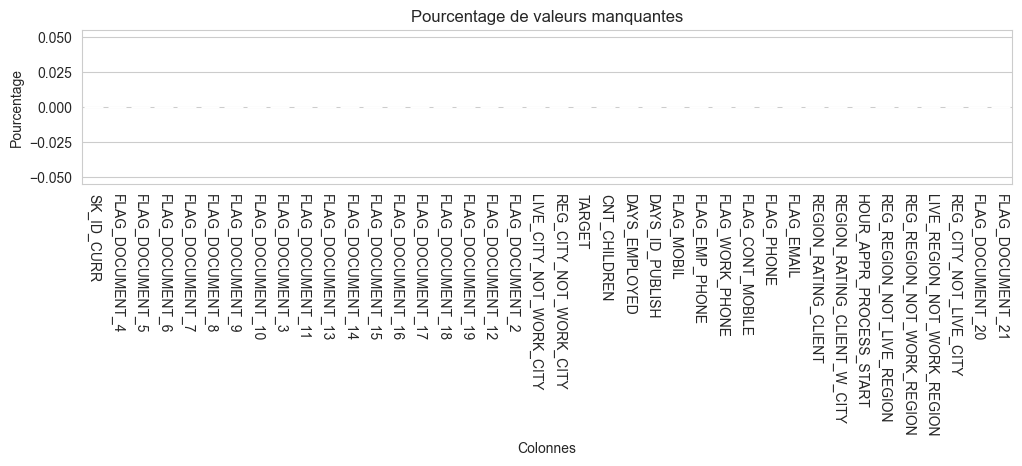

In [9]:
display_percentage_missing_chart(app_train[col_type_int64], 1)

Pas de valeurs manquantes pour les colonnes de type int64, je vais regarder les outliers

In [10]:
# Checking outliers for int64
pd.set_option("display.max_columns", None)
app_train[col_type_int64].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,63815.045904,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335
std,102790.175348,0.272419,0.722121,141275.766519,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299
min,100002.000000,0.000000,0.000000,-17912.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,-2760.000000,-4299.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,-1213.000000,-3254.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,-289.000000,-1720.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,456255.000000,1.000000,19.000000,365243.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


J'observe que les colonnes DAYS_EMPLOYED et DAYS_ID_PUBLISH on des valeurs négatives.
Concernant le reste, c'est souvent binaire.

Pour rappel des descriptions:  
	- **DAYS_EMPLOYED**   = `How many days before the application the person started current employment`  
 	- **DAYS_ID_PUBLISH** = `How many days before the application did client change the identity document with which he applied for the loan`

Pour DAYS_EMPLOYED, j'affiche un graphique de distribution des jours employés

#### _Code pour générer les graphiques suivant_

In [11]:
def display_scatter_and_hist_graph_for_column(column_name):
    prds = app_train[column_name].copy().reset_index()  

    # Create a 1x2 grid of subplots  
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))  
      
    # Scatter plot  
    sns.scatterplot(data=prds, x='index', y=column_name, ax=axs[0])  
    axs[0].set_title(f'Scatter Plot de {column_name}')  
    axs[0].set_xlabel('Index')  
    axs[0].set_ylabel(column_name)  
      
    # Histogram  
    app_train[column_name].plot.hist(ax=axs[1], bins=50)  
    axs[1].set_title(f'Histogram de {column_name}')  
    axs[1].set_xlabel(column_name)  
    axs[1].set_ylabel('Fréquence')  
      
    # Adjust the spacing between subplots  
    plt.tight_layout()  
      
    # Show the plot  
    plt.show()  

#### Résultat

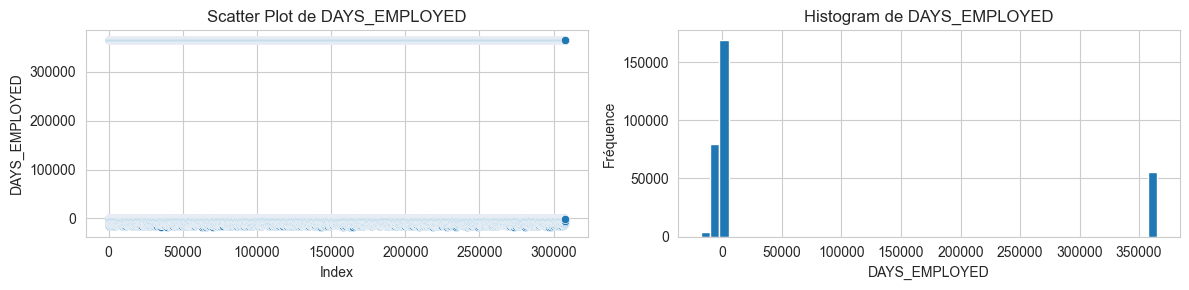

In [12]:
display_scatter_and_hist_graph_for_column("DAYS_EMPLOYED")

Je remarque que +50k valeurs sont égales à 365243.  
Ça m'a l'air d'être une erreur, on ne peut pas être employé 1000ans après avoir fait le demande de crédit, lors de la demande.  
Dans ce cas, je vais les remplacer par NaN pour continuer mon analyse sans bias.

In [13]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243 # Is employed ?
print(f"DAYS_EMPLOYED a {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")
app_train['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True) # TODO, here do the version check depending of NaN or -1 or 0.
print(f"DAYS_EMPLOYED a maintenant {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

DAYS_EMPLOYED a 0 valeurs NaN
DAYS_EMPLOYED a maintenant 55374 valeurs NaN


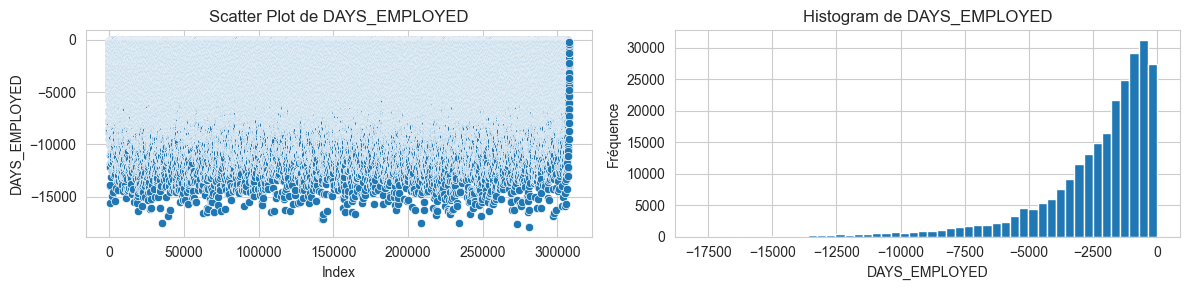

In [14]:
display_scatter_and_hist_graph_for_column("DAYS_EMPLOYED")

Ok ça me parait mieux pour effectuer mon analyse et feature engineering.  
Je vais maintenant observer l'autre colonne DAYS_ID_PUBLISH

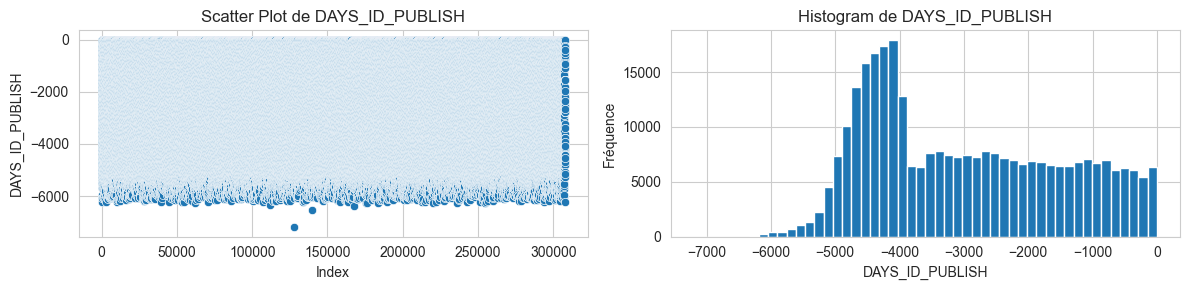

In [15]:
display_scatter_and_hist_graph_for_column("DAYS_ID_PUBLISH")

Pas de valeurs positives, ça me rassure.

### Inspection du type Object

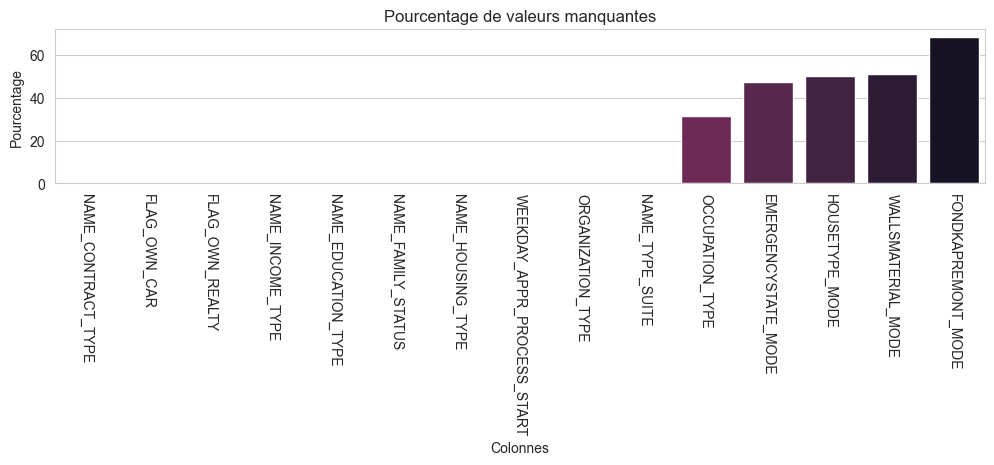

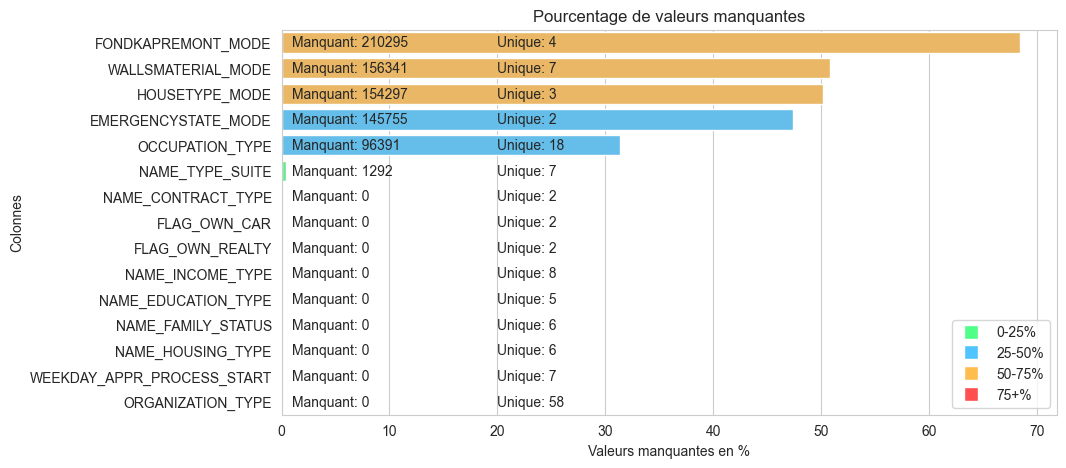

In [16]:
display_percentage_missing_chart(app_train[col_type_object], 1)
display_graph_missing_data(app_train[col_type_object], 5)

Dans ce cas de figure, n'ayant peu de colonnes unique je vais transdformer les colonnes de type object en int64 afin de pouvoir les étudier. 

Je vais utiliser deux méthodes comme défini dans le [kaggle d'exemple fourni](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction): 

- **Label Encoder** : Pour les colonnes qui n'ont que 2 valeurs (afin d'avoir un 1 ou 0),
- **One-Hot encoding**: Pour les colonnes qui ont plus que 2 valeurs, créer une colonnes en plus par valeur unique.

In [17]:
# Label encode object (<= unique type > Label encoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d colonnes transformées avec la méthode "label encoded".' % le_count)

3 colonnes transformées avec la méthode "label encoded".


In [18]:
# One-hot encoding for feature with > 2 unique values
print('app_train avant one-hot encoding: ', app_train.shape)
print('app_test avant one-hot encoding: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\napp_train après one-hot encoding: ', app_train.shape)
print('app_test après one-hot encoding: ', app_test.shape)

app_train avant one-hot encoding:  (307511, 120)
app_test avant one-hot encoding:  (48744, 120)

app_train après one-hot encoding:  (307511, 239)
app_test après one-hot encoding:  (48744, 237)


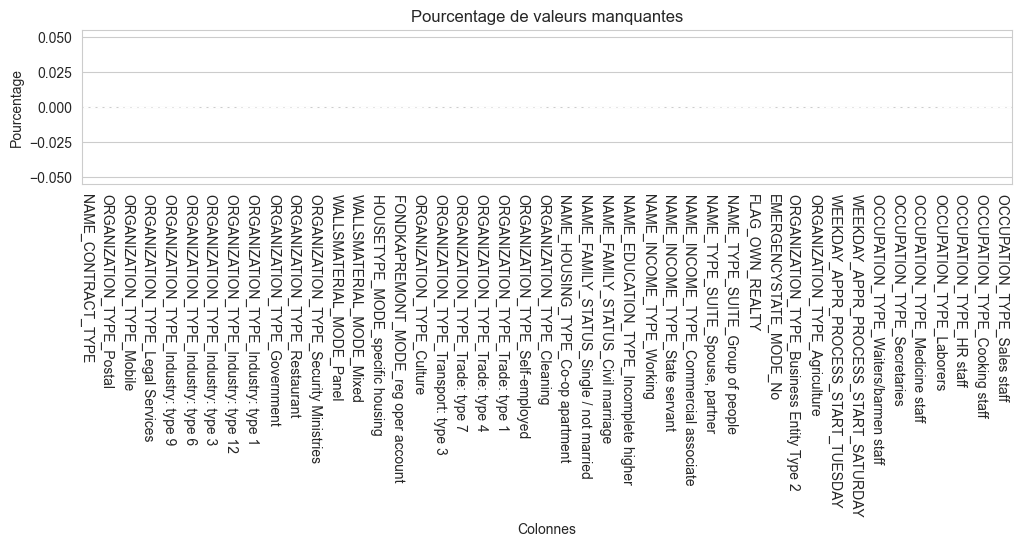

In [19]:
test_data = app_train.drop(columns=col_type_int64).drop(columns=col_type_float64)
display_percentage_missing_chart(test_data, 3)

Comme prévu, pas de valeurs manquantes.

### Inspection du type Float64

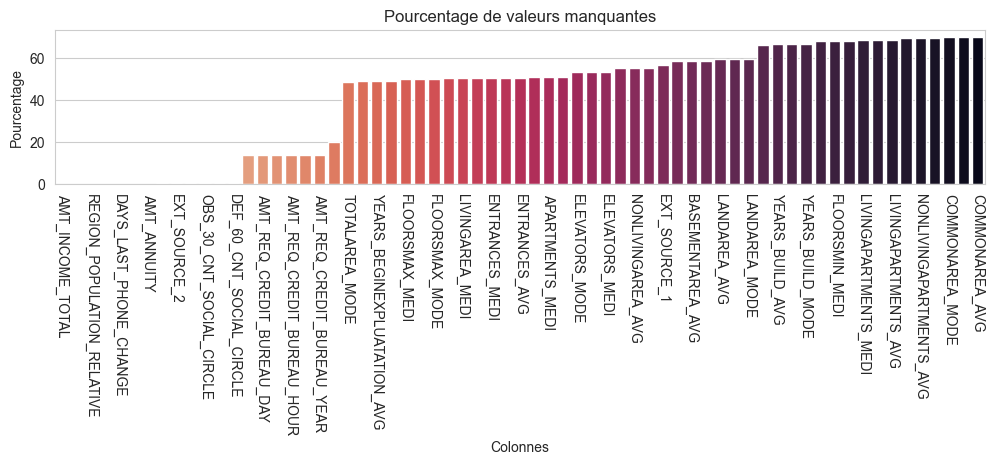

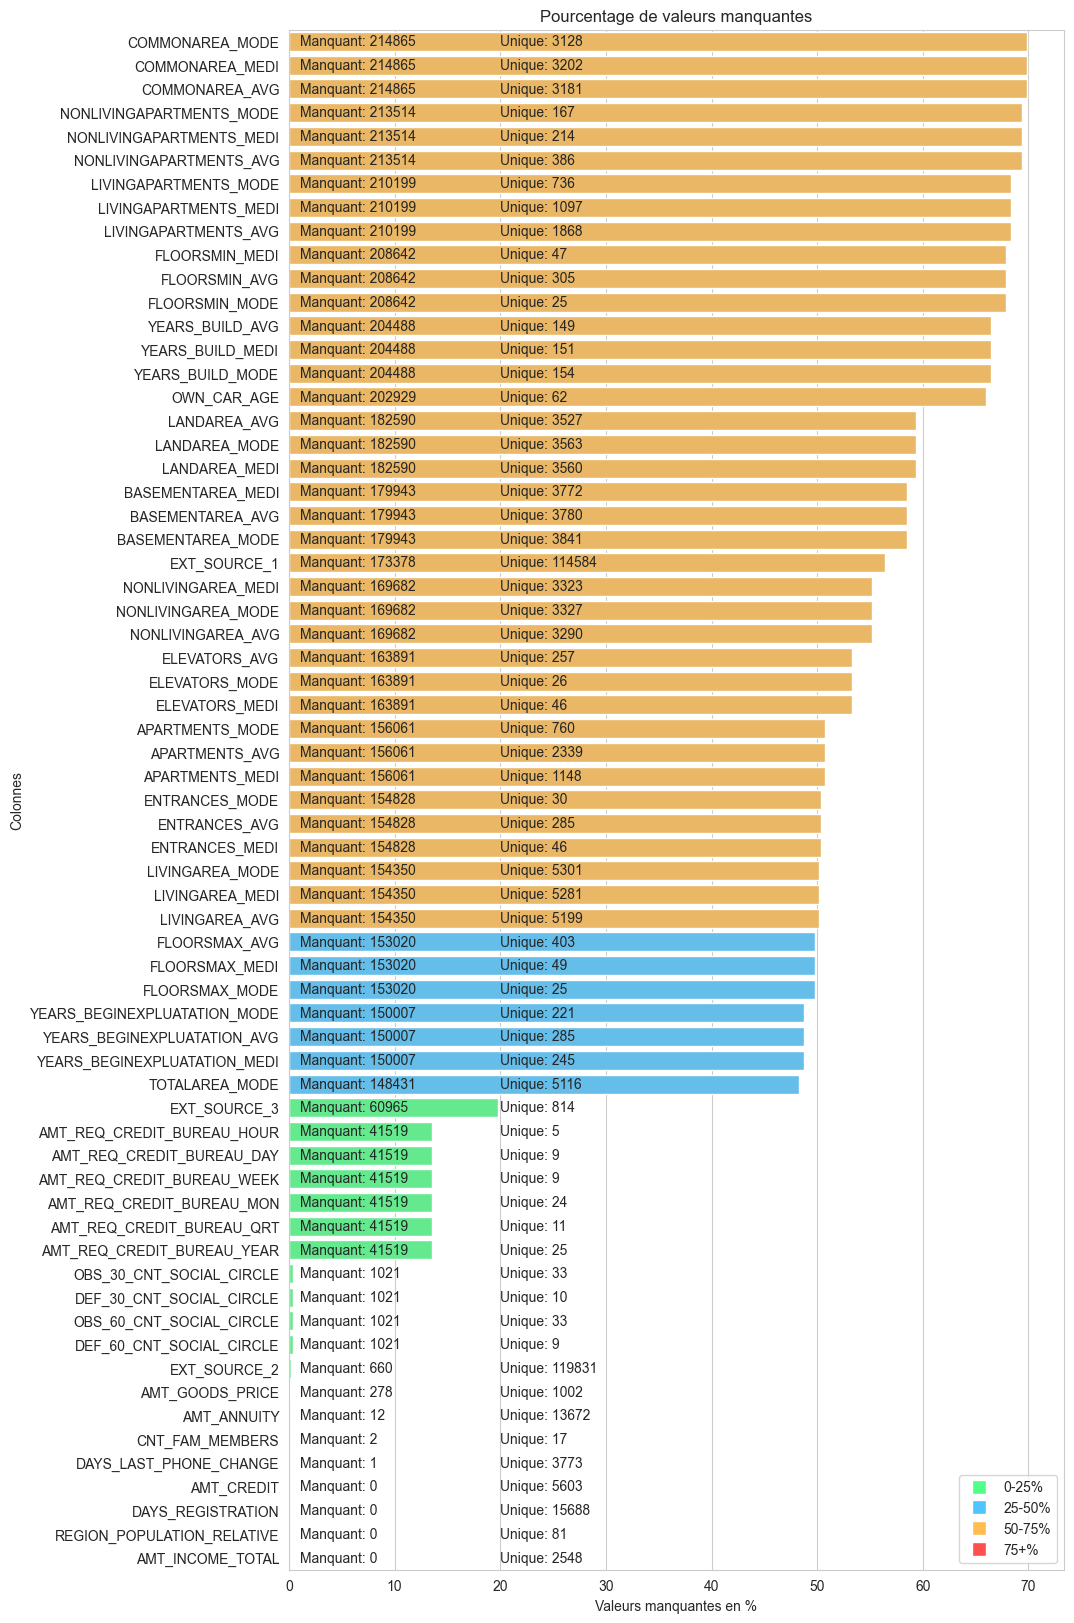

In [20]:
display_percentage_missing_chart(app_train[col_type_float64], 2)
display_graph_missing_data(app_train[col_type_float64], 20)

Beaucoup de valeurs manquantes.  
Je commence par observer les valeurs abérrantes

In [21]:
app_train[col_type_float64].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-4986.120328,12.061091,2.152665,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,3522.886321,11.944812,0.910682,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,0.161380,0.081184,0.092576,0.110565,0.047732,0.069523,0.107936,0.084307,0.064575,0.110111,0.074445,0.132256,0.100977,0.143709,0.161160,0.081750,0.097880,0.111845,0.046276,0.070254,0.109076,0.082179,0.059897,0.112066,0.076144,0.134467,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-24672.000000,0.000000,1.000000,0.014568,8.173617e-08,0.000527,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.700000e+05,16524.000000,2.3

Je vais maintenant remplacer les valeurs manquantes par différentes méthodes pour analyser le meilleur comportement.
- Suppression total des valeurs manquantes
- Remplacement des valeurs manquantes par la moyenne
- Remplacement des valeurs manquantes par la médiane
- Remplacement des valeurs manquantes par 0

In [64]:
app_train_na_deleted = app_train.copy()
app_train_na_deleted.dropna(inplace=True)

app_train_na_to_mean = app_train.copy()
app_train_na_to_mean.fillna(app_train.mean(),inplace=True)

app_train_na_to_med = app_train.copy()
app_train_na_to_med.fillna(app_train.median(),inplace=True)

app_train_na_to_zero = app_train.copy()
app_train_na_to_zero.fillna(0,inplace=True)

In [69]:
print(f'Valeurs manquantes pour app_train_na_deleted = {app_train_na_deleted.isna().sum().sum()}, shape = {app_train_na_deleted.shape}')
print(f'Valeurs manquantes pour app_train_na_to_mean = {app_train_na_to_mean.isna().sum().sum()}, shape = {app_train_na_to_mean.shape}')
print(f'Valeurs manquantes pour app_train_na_to_med  = {app_train_na_to_med.isna().sum().sum()}, shape = {app_train_na_to_med.shape}')
print(f'Valeurs manquantes pour app_train_na_to_zero = {app_train_na_to_zero.isna().sum().sum()}, shape = {app_train_na_to_zero.shape}')

print(f'\nValeurs manquantes pour app_train = {app_train.isna().sum().sum()}, shape = {app_train.shape}')

Valeurs manquantes pour app_train_na_deleted = 0, shape = (10746, 239)
Valeurs manquantes pour app_train_na_to_mean = 0, shape = (307511, 239)
Valeurs manquantes pour app_train_na_to_med  = 0, shape = (307511, 239)
Valeurs manquantes pour app_train_na_to_zero = 0, shape = (307511, 239)

Valeurs manquantes pour app_train = 8443468, shape = (307511, 239)


### Sélection des features pertinentes

In [23]:
# Remove NAN HARD
clean_app_train = app_train.copy()
print(clean_app_train.shape)

clean_app_train.dropna(inplace=True)  
print(clean_app_train.shape)

(307511, 239)
(10746, 239)


In [24]:
X = clean_app_train.drop('TARGET', axis=1)  # Exclude the target column
y = clean_app_train['TARGET']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(10746, 238)
(10746,)


In [25]:
# Todo 
# Every data that you want to keep, modify it to positive
# Every data thagt you don't to delete, modify to -1
# Todo 2 > Instead of -1, put to 0 to check the weight

In [26]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# Draw the feature importance
feature_importances = rf_model.feature_importances_
# Assuming feature_importances is a list or array containing feature importances
threshold = 0.01  # Set threshold

# Filter features based on the threshold
selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# Create a new feature matrix with selected features
X_selected = X[selected_features]

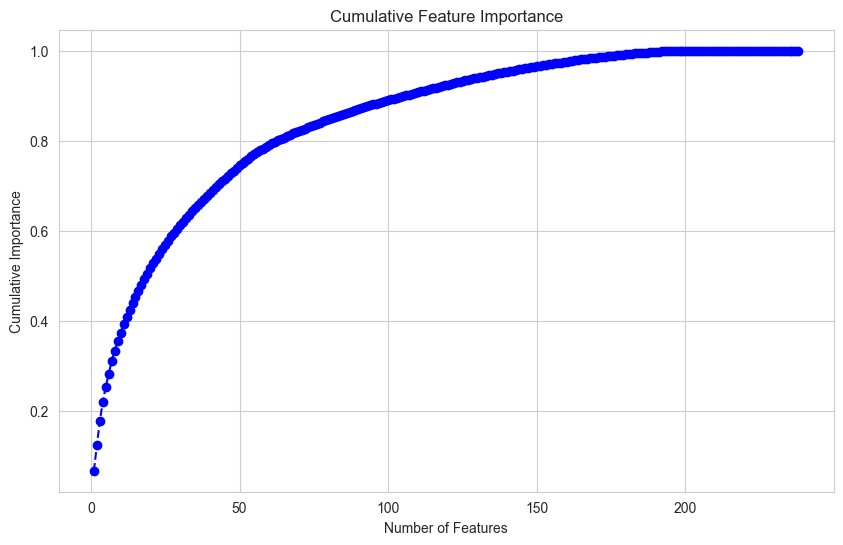

In [28]:
# list or array containing feature importances
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()
# TODO Table with score next to each columns (AGE & Gender)

In [29]:
selected_features

['SK_ID_CURR',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'COMMONAREA_AVG',
 'LANDAREA_AVG',
 'BASEMENTAREA_MODE',
 'COMMONAREA_MODE',
 'LANDAREA_MODE',
 'LIVINGAREA_MODE',
 'COMMONAREA_MEDI',
 'TOTALAREA_MODE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [30]:
# Correlation V2 
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OWN_CAR_AGE                                          0.037612
DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [31]:
print(len(correlations[correlations > threshold]))
correlations[correlations > threshold]

36


ORGANIZATION_TYPE_Restaurant                         0.010266
NAME_EDUCATION_TYPE_Lower secondary                  0.011747
OCCUPATION_TYPE_Cooking staff                        0.012222
OCCUPATION_TYPE_Security staff                       0.014648
ORGANIZATION_TYPE_Transport: type 3                  0.017552
CNT_CHILDREN                                         0.019187
OCCUPATION_TYPE_Sales staff                          0.019537
NAME_HOUSING_TYPE_Rented apartment                   0.019767
ORGANIZATION_TYPE_Construction                       0.019792
AMT_REQ_CREDIT_BUREAU_YEAR                           0.019930
NAME_FAMILY_STATUS_Civil marriage                    0.022496
ORGANIZATION_TYPE_Business Entity Type 3             0.023993
NAME_FAMILY_STATUS_Single / not married              0.026518
OCCUPATION_TYPE_Low-skill Laborers                   0.027591
FLAG_WORK_PHONE                                      0.028524
ORGANIZATION_TYPE_Self-employed                      0.029139
NAME_HOU

In [32]:
correlations[correlations > threshold].sum()
# Why 1.12, shouldn't the sum be 1 ?
# Todo, understand this

2.1962751371453684

In [33]:
# Compare randomforwest table & correlation table

In [34]:
correlations.sum()

-0.1310151812693352

### TODO

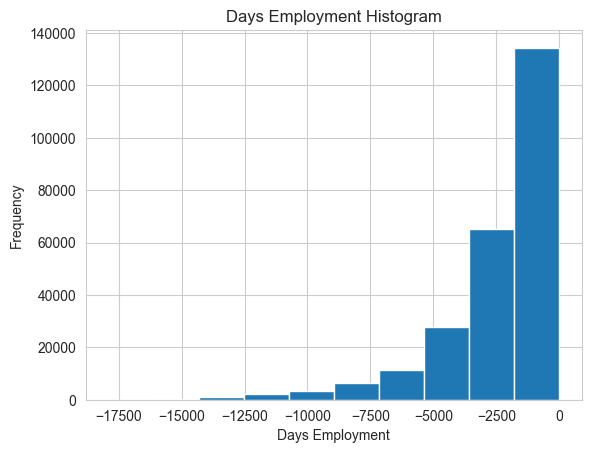

In [35]:
# Days employed 
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

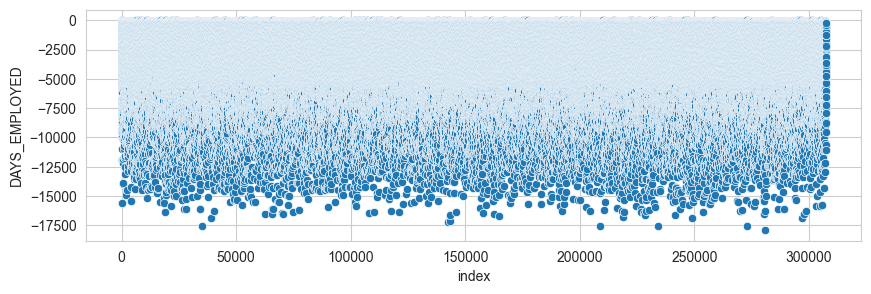

In [36]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

In [37]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

In [38]:
len(app_train[app_train['DAYS_EMPLOYED'] < 0])
# app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])

252135

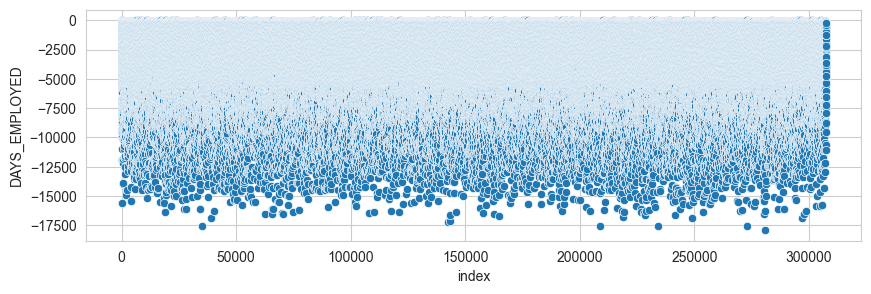

In [39]:
# Reset index for the dataframe
prds = app_train['DAYS_EMPLOYED'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_EMPLOYED')

# Show the plot
plt.show()

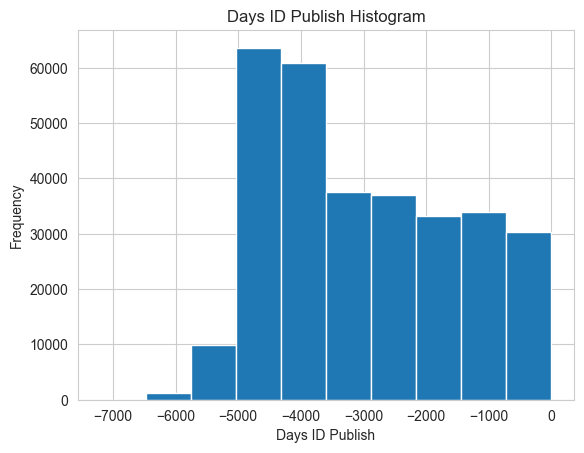

In [40]:
# Days ID publish 
app_train['DAYS_ID_PUBLISH'].plot.hist(title = 'Days ID Publish Histogram');
plt.xlabel('Days ID Publish');

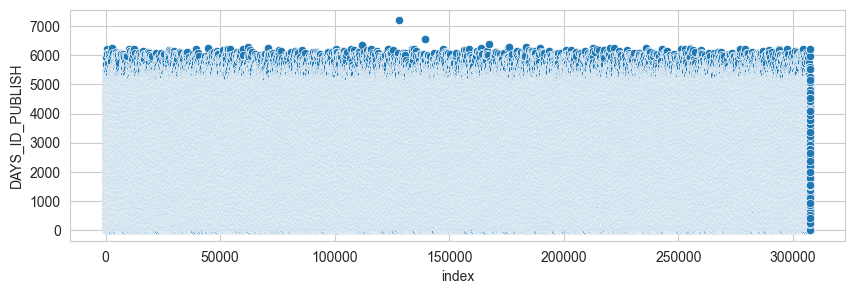

In [41]:
app_train['DAYS_ID_PUBLISH'] = abs(app_train['DAYS_ID_PUBLISH'])
# Reset index for the dataframe
prds = app_train['DAYS_ID_PUBLISH'].copy().reset_index()  
# Create scatter plot using seaborn
plt.figure(figsize=(10, 3))
sns.scatterplot(data=prds,x='index', y='DAYS_ID_PUBLISH')

# Show the plot  
plt.show()

In [42]:
# Encode categorical data

In [43]:
# Replace missing  value in object type (no need)

In [44]:
# Check outlier in all category (boxplot, awaiting)

In [45]:
# Try to replace missing value in int type ?
# You might just need to get the ome that have values

In [46]:
# No more missing value before continuing

In [47]:
# Check feature importance

# # Step 4: Build a Random Forest Model
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Step 5: Retrieve feature importances
# feature_importances = rf_model.feature_importances_

# # Display feature importances
# for feature, importance in zip(X.columns, feature_importances):
#     print(f"{feature}: {importance}")

In [48]:
# Create X and Y
# X = df.drop('target_column', axis=1)  # Exclude the target column
# y = df['target_column']

In [49]:
# Draw the feature importance

# # Assuming feature_importances is a list or array containing feature importances
# threshold = 0.01  # Set your threshold based on your analysis

# # Filter features based on the threshold
# selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# # Create a new feature matrix with selected features
# X_selected = X[selected_features]


# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming feature_importances is a list or array containing feature importances
# feature_importances = rf_model.feature_importances_

# # Sort features by importance
# sorted_idx = np.argsort(feature_importances)[::-1]
# sorted_importances = feature_importances[sorted_idx]

# # Calculate cumulative importance
# cumulative_importance = np.cumsum(sorted_importances)

# # Plot the cumulative importance
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
# plt.title('Cumulative Feature Importance')
# plt.xlabel('Number of Features')
# plt.ylabel('Cumulative Importance')
# plt.grid(True)
# plt.show()

In [50]:
# Do A PCA for potential dimention reductiona
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Assuming X is your feature matrix

# # Step 1: Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Step 2: Apply PCA
# pca = PCA()
# X_pca = pca.fit_transform(X_scaled)

# # Step 3: Plot the explained variance
# explained_variance_ratio = pca.explained_variance_ratio_

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
# plt.title('Cumulative Explained Variance by Principal Components')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()

## Analyse exploratoire

In [51]:
# Training data
app_train = pd.read_csv('../input/application_train.csv')
app_test = pd.read_csv('../input/application_test.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/application_train.csv'

In [ ]:
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

In [ ]:
def display_percentage_missing_chart(df, xticksRange):
    # Get the missing data in percentage
    missing_data = df.isna().mean() * 100

    # Sort by value asc
    missing_data = missing_data.sort_values()

    # Create the figure
    plt.figure(figsize=(12, 2))

    ## Add horizontal lines
    sns.set_style('whitegrid')

    ## Set a color palette (https://seaborn.pydata.org/tutorial/color_palettes.html)
    colors = sns.color_palette("rocket_r", len(missing_data))

    ## Create the barplot
    sns.barplot(x=missing_data.index, y=missing_data,  palette=colors) # Create the bar plot

    ## Rotate the x labels and only one out of three for better readability
    plt.xticks(rotation=-90)
    plt.xticks(range(0, len(missing_data.index), xticksRange))

    ## Set the labels
    plt.ylabel('Pourcentage')
    plt.xlabel('Colonnes')
    plt.title('Pourcentage de valeurs manquantes')
    plt.show()

def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Valeurs manquantes en %")  
    plt.ylabel("Colonnes")  
    plt.title("Pourcentage de valeurs manquantes")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Manquant: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()



In [ ]:
missing_columns = app_train.columns[app_train.isnull().any()].tolist()

In [ ]:
display_percentage_missing_chart(app_train[missing_columns], 3)

In [ ]:
display_graph_missing_data(app_train[missing_columns], 25)

In [ ]:
app_train.dtypes.value_counts()

In [ ]:
display_graph_missing_data(app_train.select_dtypes('object'), 7)

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


In [ ]:
print('Training Features shape before: ', app_train.shape)
print('Testing Features shape before: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\nTraining Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

In [ ]:
display_graph_missing_data(app_train, 40)

In [ ]:
# app_train['DAYS_BIRTH'].describe()
# (app_train['DAYS_BIRTH'] / 365).describe()

In [ ]:
X = clean_app_train.drop('TARGET', axis=1)  # Exclude the target column
y = clean_app_train['TARGET']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
# Draw the feature importance
feature_importances = rf_model.feature_importances_
# Assuming feature_importances is a list or array containing feature importances
threshold = 0.01  # Set your threshold based on your analysis

# Filter features based on the threshold
selected_features = [feature for feature, importance in zip(X.columns, feature_importances) if importance > threshold]

# Create a new feature matrix with selected features
X_selected = X[selected_features]

In [ ]:
# Assuming feature_importances is a list or array containing feature importances
feature_importances = rf_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_idx]

# Calculate cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Plot the cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.show()

In [ ]:
# Looks like around 60 features could be used

In [ ]:
selected_features

In [ ]:
app_train.shape

In [ ]:
# Correlation V2 
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

In [ ]:
print(len(correlations[correlations > threshold]))
correlations[correlations > threshold]

In [ ]:
test_corr = correlations[correlations > threshold].copy()
# Todo > Remove target accordingly
test_corr.drop(columns=["TARGET"], inplace=True)
# test_corr.sum()
test_corr.sum() - 1 # TMP


In [ ]:
test_corr

In [ ]:
# Todo > Cumulative

In [ ]:
# TODO >
# Features importances global
# Entraine un random forest avec toutes les cases, c'est mieux de les normaliser
# Excplication métier > Gain de temps en rendez-vous car moins de features.

In [ ]:
# Do A PCA for potential dimention reductiona
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 3: Plot the explained variance
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 2))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
df_PCA = app_train.drop('TARGET', axis=1)
pcs = pca.components_
pcs = pd.DataFrame(pcs)
features = df_PCA.columns
pcs.columns = features
pcs.index = [f"F{i}" for i in range(1,239)]
pcs.round(2)
pcs.T

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [ ]:
# Next steps:
# Clean the Notebook
# Finish with boxplot
# Get the 2 correlated algo (keep with 11k values)
# AFTER > (try to get more data than 11k, maybe some more columns can have 0 and update the notebook?)
# Prepare to continue the notebook with only those data
# Exploratory analysis on those columns from Kaggle
# Failure to repay depending on date of employment ?

In [ ]:
app_train['DAYS_EMPLOYED'] = abs(app_train['DAYS_EMPLOYED'])
app_train['DAYS_EMPLOYED'].corr(app_train['TARGET'])

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
# plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
# plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

# Plot the distribution of ages in years
plt.hist(abs(app_train['DAYS_EMPLOYED']) / 365, edgecolor = 'k', bins = 25)
plt.title('Age employed'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [ ]:
# Check outliers of all other columns
# Box plot of all columns

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_EMPLOYED']].copy()  
age_data.loc[:, 'YEARS_EMPLOYED'] = abs(age_data['DAYS_EMPLOYED']) / 365

# # Bin the age data

# age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); 
plt.ylabel('Density'); 
plt.title('Distribution of Ages');

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_EMPLOYED']).copy()

# Add in the age of the client in years
plot_data['YEARS_EMPLOYED'] = age_data['YEARS_EMPLOYED']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);